In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import folium
import logging

from utils import *

from sklearn.metrics import root_mean_squared_error

logging.basicConfig(level=logging.INFO)

#### Preparando o dataset

In [2]:
data = pd.read_csv('../data/raw_data/data.csv')

In [3]:
# Separando o dataset em conjuntos de Treino e Teste
df_train, _,  df_test = split_data(data, 0.8, 0, 0.2)

In [4]:
print(df_train.shape[0])
print(df_test.shape[0])

5420
1355


In [5]:
# Selecionando as variáveis alvos
X_test = df_test.drop(['indoor', 'lat', 'lon'], axis=1)
y_test = df_test[['lat', 'lon']].values

#### Criando a função de Fingerprint

In [6]:
def fingerprint(df_train, test_instance):
    """
    Encontra o ponto no DataFrame de treino que está mais próximo do ponto de teste,
    considerando as colunas de RSSI e delay.
    """
    columns = [
        'rssi_1_1', 'rssi_1_2', 'rssi_1_3',
        'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
        'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
        'delay_1', 'delay_2', 'delay_3'
    ]
    
    ref_point = test_instance[columns]
    
    # Euclidian distance
    distances = np.sqrt(((df_train[columns] - ref_point) ** 2).sum(axis=1))
    min_index = distances.idxmin()
    closest_point = df_train.loc[min_index]
    
    return closest_point['lat'], closest_point['lon']   

In [7]:
# Função para calcular a posição estimada para cada ponto
def fingerprint_predict(pontos_df):
    y_pred = []
    for _, ponto in pontos_df.iterrows():
        y_pred.append(fingerprint(df_train, ponto))

    return y_pred

#### Avaliando o modelo

In [8]:
y_pred = fingerprint_predict(X_test)

In [9]:
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.02133366804246056


In [10]:
accuracy = calculate_accuracy(y_pred, y_test)
print(f"Acurácia: {accuracy:.3f}")

Acurácia: 0.793


In [11]:
distances = get_error_distances(y_pred, y_test)
print_errors(distances)

Erro de localização médio: 20.113 metros
Erro mínimo: 0.0 metros
Erro máximo: 655.772 metros
Desvio Padrão do erro: 68.438 metros


#### BoxPlot

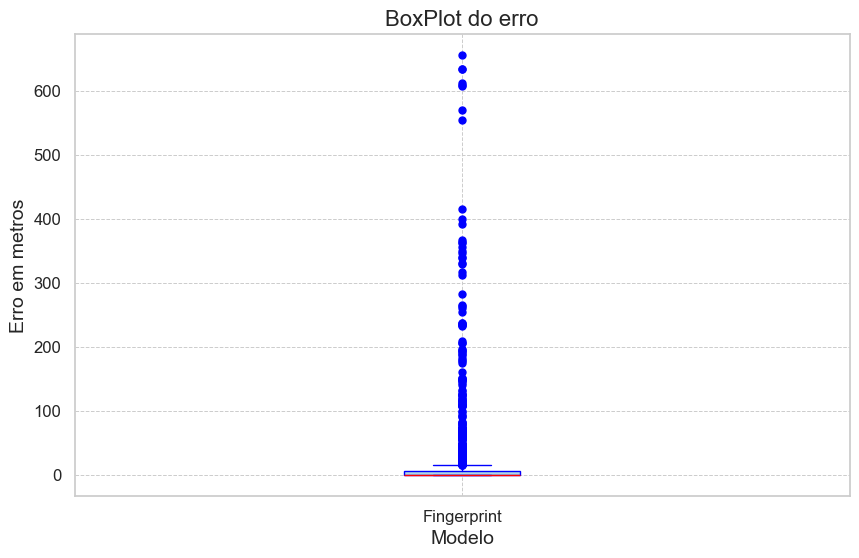

In [12]:
plot_boxplot('Fingerprint', distances)

#### Histograma dos Erros

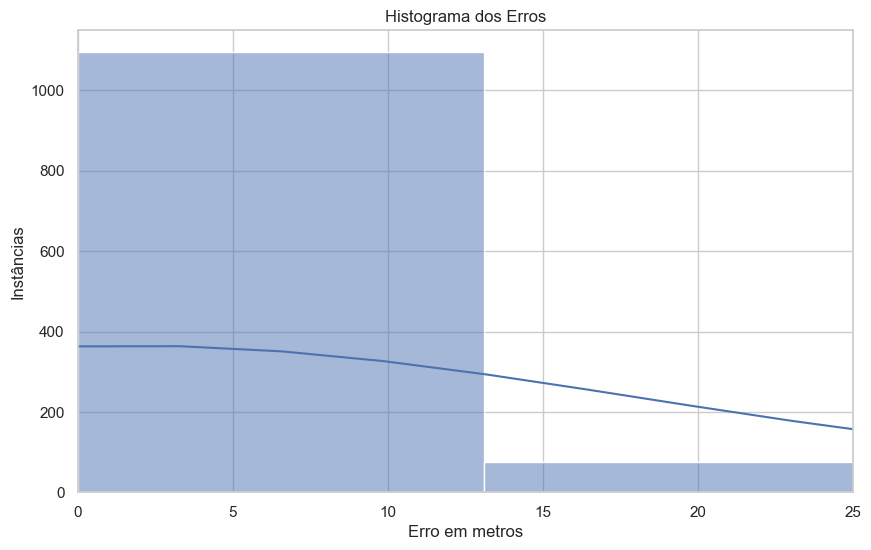

In [13]:
plot_histogram(distances)

In [14]:
print(f"Total de distâncias: {len(distances)}")
print(f"Distâncias com menos de 25 Metros de erro: {np.sum(distances <= 25)}")

Total de distâncias: 1355
Distâncias com menos de 25 Metros de erro: 1164


#### Visualização dos Mapas

In [15]:
map = plot_folium_map(y_test, y_pred, True)
map

In [17]:
map = plot_folium_map(y_pred, y_test, False)
map